## The Shirley Background
The Shirley background is the most commonly-used backgrounds in fitting XPS spectra with syntheitc peaks. Although the Shirley line-shape is not actually based on a physical model of electron scattering, it gives a reasonably good estimate of the background in many cases (although caution must be used, as non-sensical lineshapes can arise).
Here, we will show using Python code, how one can calculate the Shirley background for an XPS spectrum. 

In [1]:
# First import some libraries
import matplotlib.pyplot as plt # This is for plotting
from converters.data_converter import DataConverter # This is for importing a spectrum from Vamas format


Here we have a synthetic spectrum to use as an example. Let's load it in.

In [3]:
url = r"https://raw.githubusercontent.com/mgreiner79/shirley_background_tutorial/main/Shirley_example.vms"
converter  = DataConverter()
converter.load(url, in_format = 'Vamas')
d = converter.data

Now let's plot it and see how it looks.

Text(0.5, 1.0, 'Example spectrum')

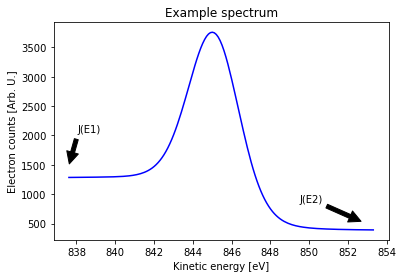

In [4]:
E = d[0]['data']['x'] # The x values
J = d[0]['data']['y'] # The y values

fig, ax = plt.subplots()
ax.annotate('J(E1)', xy=(0.17, 0.40),  xycoords='figure fraction', xytext=(0.25,0.55), textcoords='figure fraction',
           arrowprops=dict(facecolor='black', shrink=0.08),
            horizontalalignment='right', verticalalignment='top')
ax.annotate('J(E2)', xy=(0.9, 0.20),  xycoords='figure fraction', xytext=(0.8,0.3), textcoords='figure fraction',
           arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')
ax.plot(E,J, color='blue')
ax.set_xlabel('Kinetic energy [eV]')
ax.set_ylabel('Electron counts [Arb. U.]')
ax.set_title('Example spectrum')


We'll denote the line-shape of our spectrum with $J(E)$. You see that on the right side of the peak, the background is lower than on the left side of the peak. This is very typical for XPS spectra. The increase in background on the left-side of the peak is a result of inelastic scattering of electrons. Let's try fitting this peak with a Shirley background.

 The Shriley background line-shape has the following form:

$$B_{Sh}(E) = I_2 + (I_1 - I_2) \frac{A_2 (E)}{A_1 (E) + A_2 (E)}$$

Where $B_{Sh}(E)$ is the line-shape of the Shirley background, $I_1$ and $I_2$ represent the measured signal intensities at the boundaries of the background (i.e. $I_1 = J(E_1)$ and $I_2 = J(E_2)$), and $A_1 (E)$ and $A_2 (E)$ are the areas bound between the measured spectrum and the background line-shape, to the left and to the right of point $E$, respectively.

In words, thie equation says that the intensity of the background at some point E, is the intensity of the spectrum on the low side of the range ($I_2$) , plus the differe between the intensities at the high-end and low-end of the range ($I_1 - I_2$), multiplied by the fraction of the peak area on the right of E, to the total peak area.

The actual form of the background line-shape is then calculated iteratively using the following equation: $$B_{Sh_{n+1}}(E) = I_2 + \frac{I_1 - I_2}{\int_{E_1}^{E_2} J(x) - B_{Sh_{n}}(x)dx} \int_{E}^{E_2} J(x)-B_{Sh_{n}}(x)dx$$

This equation gives us the line-shape of the background at the $(n+1)^{th}$ iteration, using integrals of the background line-shape for the $n^{th}$ iteration.

Let's put this equation into Python. Firs, we'll break it equation into parts, for clarity. Well evaluate the two integrals separately, then combine them together, and compute $B_{SH_{n}}$ iteratively. 
Let's put the integrals into functions. The function for the integral in the denominator of the fraction we'll call 'integralOne' and the integral in the numerator we'll call 'integralTwo'.

In [5]:
def integralOne(E, J, B, E1=0, E2=-1):
    integral = []
    if E2 < 0:
        E2 = len(J) + E2
    integral = sum([J[n] - B[n] for n in range(E,E2)])
    return integral

def integralTwo(E, I, B, E1=0, E2=-1):
    integral = []
    if E2 < 0:
        E2 = len(I) + E2
    integral = sum([I[n] - B[n] for n in range(E1,E2)])
    return integral

Now we combine both integrals by calling them in a function called 'getBn', which will return the value of $B_{Sh_{n}}$ at a given value of $E$.

In [6]:
def getBn(E,I,B,E1=0,E2=-1):
    I2 = I[E2]
    I1 = I[E1]
    value = I2 + (I1 - I2)/(integralTwo(E,I,B,E1,E2))*integralOne(E,I,B,E1,E2)
    return value

Ok. Now let's wrap everything in a function that repeats calls to the function 'getBn' for all $E$ in our range, and returns the values a list. Thus the list of values represents our background line-shape at the $n^{th}$ iteration. We'll call this function 'iterateOnce'.

In [7]:
def iterateOnce(I,B,E1=0,E2=-1):
    b = [getBn(E,I,B,E1,E2) for E in range(len(I))]
    return b

Before we can run the iterations, we need a starting line-shape for our background. The is, we need $B_{Sh_{n=0}}$. Let's just pick an list of zeros for this.

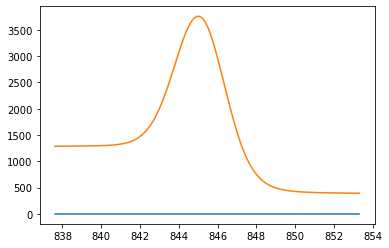

In [8]:
Bn = [0 for i in range(len(J))]
plt.plot(E, Bn)
plt.plot(E, J)
plt.show()

Ok. Now let's iterate once and see how it looks.

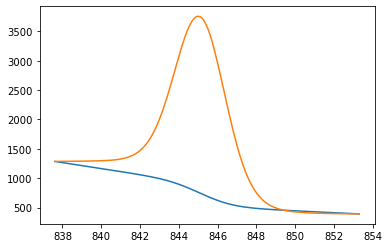

In [9]:
Bn = iterateOnce(J,Bn)
plt.plot(E, Bn)
plt.plot(E, J)
plt.show()

Not too shabby. But I think it has not yet converged.
Let's iterate a few more times.

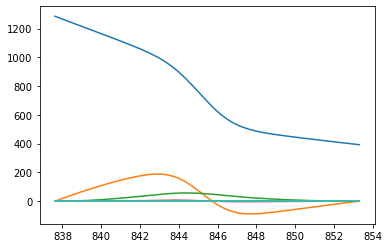

In [10]:
# Re-initiate the background line-shape.
Bn = [0 for i in range(len(J))]
# Iterate a few times.
for i in range(10):
    B_temp = Bn
    Bn = iterateOnce(J,Bn)
    B_diff = [Bn[j] - B_temp[j] for j in range(len(Bn))]
    plt.plot(E, B_diff)
# Plot how the difference between iterations looks.
# A flat line means it has converged
plt.show()


That converged fast. 
Let's look at the final product.

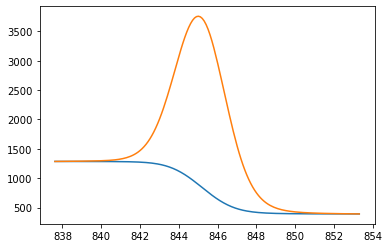

In [10]:
plt.plot(E, Bn)
plt.plot(E, J)
plt.show()

Great! We have a Shirley background!